# Task2: Write a classifier using any AI/ML technique to classify a given novel set of abstracts 

**Author**: Ariful Mondal (ariful.mondal@gmail.com)

**Date**: 13 February 2021

1. Read raw data
2. Preprocessing 
3. Feature Creating and Engineering, Vectorization
4. Train/Test Split 
5. Build simple classifiers 
6. Cross Validation 
7. Future Plans

### Import required python libraries

In [4]:
#import warnings
#warnings.simplefilter(action = 'ignore', category = ('DeprecationWarning'))
import nltk
import numpy
import pandas as pd
import re
import string
import pickle 

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, cross_val_score
import time

### Saved dataframe with abstracts

In [2]:
#read saved dataframe 
df_abst = pickle.load( open("../data/df_pubmed_asbtract_combined.pkl", "rb" ) )

In [5]:
df_abst.head()

,PMID,ArticleTitle,AbstractText,Label
0,33530226,Efficacy and safety of TCM therapies combined ...,Gastric cancer (GC) has high incidence and mor...,Adverse Drug Effect
1,33530221,Traditional Chinese medicine on treating myelo...,Myelosuppression after chemotherapy is a commo...,Adverse Drug Effect
2,33530168,The laser combined with intravitreal injection...,"At present, laser is regarded as an effective ...",Adverse Drug Effect
3,33526722,PHOTODYNAMIC THERAPY IN TREATMENT OF PATIENTS ...,The aim of the study is to evaluate the tolera...,Adverse Drug Effect
4,33517299,Adverse Events and Economic Burden Among Patie...,Limited published real-world data describe adv...,Adverse Drug Effect


In [3]:
df_abst.shape

(10053, 4)

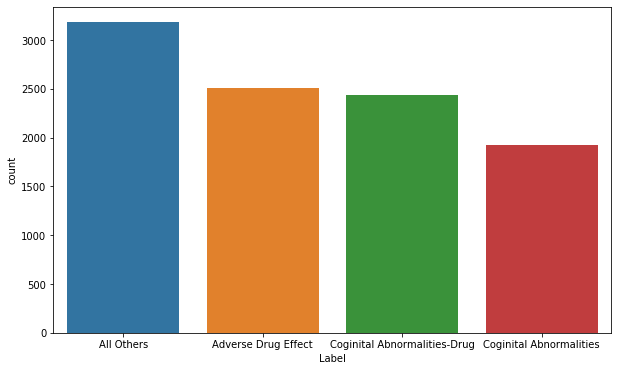

In [7]:
plt.figure(figsize = (10,6))
ax = sns.countplot(x="Label",data=df_abst, order = df_abst['Label'].value_counts().index)

### Preprocess Abstracts and Labels

I am using simple cat.codes. There are various methods can be adopted such as LabelEncoder - from sklearn.preprocessing import LabelEncoder

In [7]:
df_abst['AbstractText'] = df_abst['AbstractText'].astype('str')
df_abst['Label'] = df_abst['Label'].astype('category')

In [8]:
# Assigning numerical values to the label
df_abst['y'] = df_abst['Label'].cat.codes 
df_abst



,PMID,ArticleTitle,AbstractText,Label,y
0,33530226,Efficacy and safety of TCM therapies combined ...,Gastric cancer (GC) has high incidence and mor...,Adverse Drug Effect,0
1,33530221,Traditional Chinese medicine on treating myelo...,Myelosuppression after chemotherapy is a commo...,Adverse Drug Effect,0
2,33530168,The laser combined with intravitreal injection...,"At present, laser is regarded as an effective ...",Adverse Drug Effect,0
3,33526722,PHOTODYNAMIC THERAPY IN TREATMENT OF PATIENTS ...,The aim of the study is to evaluate the tolera...,Adverse Drug Effect,0
4,33517299,Adverse Events and Economic Burden Among Patie...,Limited published real-world data describe adv...,Adverse Drug Effect,0
...,...,...,...,...,...
4410,30422057,Lateral kinetic proficiency and asymmetry in b...,=Â -0.733 and -0.833 for feet horizontal impul...,All Others,1
4411,30411999,Effect of high volume stretch-shortening cycle...,Â <Â 0.05). Muscle damaging exercise volume is...,All Others,1
4412,29768094,Lower limb stiffness testing in athletic perfo...,Stiffness describes the resistance of a body t...,All Others,1
4413,29460656,Are skin equipment for assessing childhood ecz...,Symptomatology and severity of atopic dermatit...,All Others,1


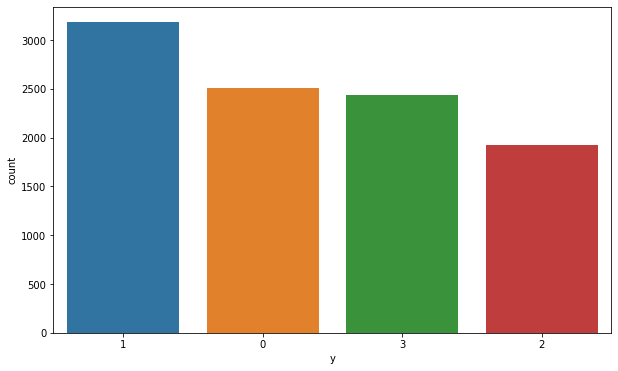

In [28]:
plt.figure(figsize = (10,6))
ax = sns.countplot(x="y",data=df_abst, order = df_abst['y'].value_counts().index)

In [17]:
df_abst["Label"].value_counts()

All Others                      3183
Adverse Drug Effect             2508
Coginital Abnormalities-Drug    2434
Coginital Abnormalities         1928
Name: Label, dtype: int64

In [18]:
df_abst["y"].value_counts()

1    3183
0    2508
3    2434
2    1928
Name: y, dtype: int64

#### Feature engineering, create some basic features

Performing basic feature creating and feature engineering. There are various other features could be created to improve accuracy

In [9]:
# download stop words from NLTK library (can be extended to own stop words)
stopwords = nltk.corpus.stopwords.words('english')

# initialize stemmer using PorterStemmer
ps = nltk.PorterStemmer()

# define function to count number of punctuations
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 4)*100

# Define function for Stemming words, removing special characters and stop words 
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation]) 
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords] 
    return text

# create  couple of new features 
df_abst['abst_len'] = df_abst['AbstractText'].apply(lambda x: len(x) - x.count(" "))
df_abst['punct%'] = df_abst['AbstractText'].apply(lambda x: count_punct(x))

In [11]:
df_abst.head()

,PMID,ArticleTitle,AbstractText,Label,y,abst_len,punct%
0,33530226,Efficacy and safety of TCM therapies combined ...,Gastric cancer (GC) has high incidence and mor...,Adverse Drug Effect,0,1622,2.47
1,33530221,Traditional Chinese medicine on treating myelo...,Myelosuppression after chemotherapy is a commo...,Adverse Drug Effect,0,2058,3.40
2,33530168,The laser combined with intravitreal injection...,"At present, laser is regarded as an effective ...",Adverse Drug Effect,0,1870,1.55
3,33526722,PHOTODYNAMIC THERAPY IN TREATMENT OF PATIENTS ...,The aim of the study is to evaluate the tolera...,Adverse Drug Effect,0,1676,4.00
4,33517299,Adverse Events and Economic Burden Among Patie...,Limited published real-world data describe adv...,Adverse Drug Effect,0,951,7.26


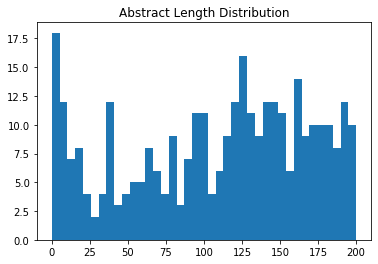

In [51]:
bins = numpy.linspace(0, 200, 40)

plt.hist(df_abst['abst_len'], bins)
plt.title("Abstract Length Distribution")
plt.show()

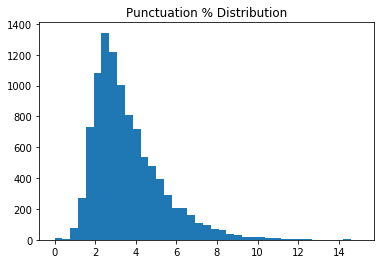

In [55]:
bins = numpy.linspace(0, 15, 40)

plt.hist(df_abst['punct%'], bins)
plt.title("Punctuation % Distribution")
plt.show()

**Note**: Similarly, various other features can be created

### Split into train/test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df_abst[['AbstractText', 'abst_len', 'punct%']], df_abst['y'], test_size=0.2)

### Vectorize text

I am using simple TF/IDF techniques. We may explore various other techniques and evaluate performance such as Word2Vec, Glove, LDA etc.

In [11]:
tfidf_vect = TfidfVectorizer(analyzer=clean_text)

In [12]:
tfidf_vect_fit = tfidf_vect.fit(X_train['AbstractText'])

tfidf_train = tfidf_vect_fit.transform(X_train['AbstractText'])
tfidf_test = tfidf_vect_fit.transform(X_test['AbstractText'])

X_train_vect = pd.concat([X_train[['abst_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['abst_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head()

,abst_len,punct%,0,1,2,3,4,5,6,7,...,54229,54230,54231,54232,54233,54234,54235,54236,54237,54238
0,1452,3.72,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,856,2.45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,600,2.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1637,2.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1384,3.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
X_train_vect.shape

(8042, 54241)

Note: It's quite a large feature matrix. Required further dimension reduction analysis. Will do it in future.

### Train Classification Models 

#### Model 1: Simple Classifier - with a Random Forest classifier

In [19]:
#from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1)

start = time.time()
rf_model = rf.fit(X_train_vect, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred_rf = rf_model.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

accuracy_rf = rf_model.score(X_test_vect, y_test) 
print(accuracy_rf)

# creating a confusion matrix 
cm_rf = confusion_matrix(y_test, y_pred_rf)


0.7598209845847836


In [20]:
print(cm_rf)

[[417  76   4  17]
 [ 39 540   9  25]
 [ 10 107 194  82]
 [ 35  24  55 377]]


In [21]:
# from sklearn import metrics
print(metrics.classification_report(y_test, y_pred_rf, target_names=df_abst['Label'].unique()))

                              precision    recall  f1-score   support

         Adverse Drug Effect       0.83      0.81      0.82       514
     Coginital Abnormalities       0.72      0.88      0.79       613
Coginital Abnormalities-Drug       0.74      0.49      0.59       393
                  All Others       0.75      0.77      0.76       491

                 avg / total       0.76      0.76      0.75      2011



Random Forest classifiers seems to be apPretty good model to start with. Further tuning can be performed.

#### Model 2: Simple Classifier - with  a Naive Bayes Classifier

In [16]:
# from sklearn.naive_bayes import MultinomialNB

mcnb = MultinomialNB()

start = time.time()
mcnb_model = mcnb.fit(X_train_vect, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred_mcnb = mcnb_model.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

accuracy_mcnb = mcnb_model.score(X_test_vect, y_test) 
print(accuracy_mcnb)

# creating a confusion matrix 
cm_mcnb = confusion_matrix(y_test, y_pred_mcnb)

0.34361014420686226


In [17]:
print(cm_mcnb)

[[ 41 472   0   1]
 [  1 611   0   1]
 [  0 382   1  10]
 [  1 451   1  38]]


In [18]:
print(metrics.classification_report(y_test, y_pred_mcnb, target_names=df_abst['Label'].unique()))

                              precision    recall  f1-score   support

         Adverse Drug Effect       0.95      0.08      0.15       514
     Coginital Abnormalities       0.32      1.00      0.48       613
Coginital Abnormalities-Drug       0.50      0.00      0.01       393
                  All Others       0.76      0.08      0.14       491

                 avg / total       0.62      0.34      0.22      2011



Performance of Naive Bayes is not close enough to Random Forest Classifier. Requires further investigation.

#### Model 3: A simple classifier  - with Logistic Regression

In [27]:
# from sklearn.linear_model import LogisticRegression

mlogit = LogisticRegression(random_state=0)

start = time.time()
mlogit_model = mlogit.fit(X_train_vect, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred_mlogit = mlogit_model.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

accuracy_mlogit = mlogit_model.score(X_test_vect, y_test) 
print(accuracy_mlogit)

# creating a confusion matrix 
cm_mlogit = confusion_matrix(y_test, y_pred_mlogit)

0.7961213326703133


In [24]:
print(cm_mlogit)

[[408  76   8  22]
 [ 36 548  14  15]
 [  8  75 252  58]
 [ 24  23  51 393]]


In [25]:
print(metrics.classification_report(y_test, y_pred_mlogit, target_names=df_abst['Label'].unique()))

                              precision    recall  f1-score   support

         Adverse Drug Effect       0.86      0.79      0.82       514
     Coginital Abnormalities       0.76      0.89      0.82       613
Coginital Abnormalities-Drug       0.78      0.64      0.70       393
                  All Others       0.81      0.80      0.80       491

                 avg / total       0.80      0.80      0.79      2011



Multinomial logistic regression seems to be a very good classifier to start with. It's performance is better than my Random Forest Classifier.

#### Model 4: A simple classifier with Neural Network

In [28]:
# from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(alpha=1, max_iter=1000)

start = time.time()
mlp_model = mlp.fit(X_train_vect, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred_mlp = mlp_model.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

accuracy_mlp = mlp_model.score(X_test_vect, y_test) 
print(accuracy_mlp)

# creating a confusion matrix 
cm_mlp = confusion_matrix(y_test, y_pred_mlp)

0.29338637493784187


In [29]:
print(cm_mlp)

[[ 18  28   0 468]
 [  0  85   0 528]
 [  0  12   2 379]
 [  1   5   0 485]]


In [30]:
print(metrics.classification_report(y_test, y_pred_mlp, target_names=df_abst['Label'].unique()))

                              precision    recall  f1-score   support

         Adverse Drug Effect       0.95      0.04      0.07       514
     Coginital Abnormalities       0.65      0.14      0.23       613
Coginital Abnormalities-Drug       1.00      0.01      0.01       393
                  All Others       0.26      0.99      0.41       491

                 avg / total       0.70      0.29      0.19      2011



Performance - not enough. Required further investigation and fine tuning!

### Classifier KFold Cross validation 

As our training set is a quite large, I am not combining training and test sets for Cross Validation.

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

# define the reference model
mlogit_cv = LogisticRegression(random_state=0)
kF = KFold(n_splits=5, random_state=1)
scores = cross_val_score(mlogit_cv, X_train_vect, y_train, scoring='accuracy', cv=kF, n_jobs=-1)
scores

/home/ariful/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/ariful/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/ariful/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/ariful/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/ariful/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Us

/home/ariful/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/ariful/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/ariful/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/ariful/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/ariful/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Us

/home/ariful/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/ariful/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/ariful/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/ariful/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/ariful/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Us

/home/ariful/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/ariful/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/ariful/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/ariful/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/ariful/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Us

In [ ]:
# summarize performance
print('Average Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))